In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf
from skmultiflow.drift_detection import PageHinkley, ADWIN
from skmultiflow.data import DataStream
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr
from scipy.stats import entropy
from tensorflow import keras
from sklearn import preprocessing
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [3]:
def get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
def DP_get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def DP_get_initial_model_2(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
def node_comparison1(node1, node2, epsilon=0.05): #this function is to see if the nodes are atmost epsilon distance apart
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(math.sqrt((x-y)*(x-y))<=epsilon):
            continue
        else:
            return False
  return True

In [8]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [9]:
def layer_comparison(layer1, layer2): #compare same layers in two different DNNs
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [10]:
def check_models(Model_weights1, Model_weights2): # compare two deep neural networks based on their weights
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [11]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    
    mean_size=len(models_weights)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [12]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [13]:
# custom functions for f1, precision and recall

from keras import backend as K
from sklearn import preprocessing

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# A function to check if the two samples are different:
def return_samples(Positive, Negative, data, N):
    datasets=[]
    positiveN=int((Positive.shape[0]/data.shape[0])*N)
    negativeN=int(N-positiveN)
    print(negativeN)
    while (Positive.empty==False and Negative.empty==False):
        df1=Positive.sample(min(positiveN, len(Positive)))
        Positive.drop(df1.index, inplace=True)
        """
        drop_df1=np.random.choice(df1.index,(int)(min(positiveN, math.ceil(len(Positive))/2)), replace=False)
        if len(Positive)<positiveN:
            Positive.drop(df1.index, inplace=True)
        else:
            Positive.drop(drop_df1, inplace=True)
        #print(len(Positive))
        """
        df2=Negative.sample(min(negativeN, len(Negative)))
        Negative.drop(df2.index, inplace=True)
        """
        drop_df2 = np.random.choice(df2.index,(int)(min(negativeN, math.ceil(len(Negative))/2)))
        if len(Negative)<negativeN:
            Negative.drop(df2.index, inplace = True)
        else:
            Negative.drop(drop_df2, inplace=True)
        """
        dataset=df1.append(df2, ignore_index=True)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        datasets.append(dataset)
    print("returned datasets")
    return datasets

In [15]:
#generate sampele which are plausible deniable
#there exists a data lets say data
def generate_samples(data, num_samples, N):
    samples=[]
    intersection=[]
    while num_samples>0:    
        Positive = data[data[target_variable]==0]
        Negative = data[data[target_variable]==1]
        positiveN=int((Positive.shape[0]/data.shape[0])*N)
        negativeN=int(N-positiveN)
        df1=Positive.sample(min(positiveN, len(Positive)))
        #Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(min(negativeN, len(Negative)))
        #Negative.drop(df2.index, inplace=True)
        sample=df1.append(df2, ignore_index=False)
        samples.append(sample)
        num_samples-=1

    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = random.randint(0, len(samples)-1)
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [16]:
#generate sampele which are plausible deniable multiclass
#there exists a data lets say data
def generate_samples_multi(data, num_samples, N):
    samples=[]
    intersection=[]
    labels = [0,1,2,3,4,5,6,7,8,9]
    len_clas=[]
    data_cls=[]
    target_variable='out'
    print((data[data[target_variable]==labels[9]]))
    
    for i in range(len(labels)):
        data_cls.append(data[data[target_variable]==labels[i]])
        len_clas.append(min(int((data_cls[i].shape[0]/5)), 1))
    print(len(data_cls))
    while num_samples>0:  
        for i in range(len(labels)):
            if i==0:
                df=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
            else:
                df1=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
                df=df.append(df1, ignore_index = True)
        df=df.sample(frac=1)
        df=df.sample(frac=1)
        df=df.sample(frac=1)
        samples.append(df)
        num_samples-=1
    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = 0 #here intentionally done 0 fas poker has enough number of 0 class
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [17]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights(add_weights[i],data.shape[1]-1, 2))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable])
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model(X_test.shape[1], 2)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [18]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation_2(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights_2(add_weights[i],data.shape[1]-1, 2))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable])
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model_2(X_test.shape[1], 2)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [19]:
def drift_detection(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable])
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model(incoming_data.shape[1]-1, 2)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [20]:
def drift_detection_2(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable])
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model_2(incoming_data.shape[1]-1, 2)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [21]:
def update_train_data(train_data, incoming_data):
    train_data.drop(index=train_data.index[:len(incoming_data)], inplace=True)
    train_data=train_data.append(incoming_data, ignore_index=True)
    return train_data

In [22]:
dataset = pd.read_csv("SUSY.csv",sep=',', header=None)
dataset.round(3)
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
target_variable=0
print(dataset.head)

<bound method NDFrame.head of           0         1         2         3         4         5         6   \
0        0.0  0.035371  0.655669  0.838999  0.022344  0.077551  0.247887   
1        1.0  0.069615  0.515424  0.146879  0.002377  0.417663  0.982085   
2        1.0  0.009358  0.468216  0.295368  0.000709  0.108141  0.278343   
3        1.0  0.006226  0.267992  0.699770  0.000625  0.716446  0.304672   
4        1.0  0.051980  0.336027  0.305084  0.035597  0.331627  0.679500   
...      ...       ...       ...       ...       ...       ...       ...   
4999995  1.0  0.029482  0.271408  0.071337  0.007655  0.619779  0.975001   
4999996  0.0  0.034323  0.533305  0.914125  0.013858  0.414505  0.286360   
4999997  0.0  0.028845  0.837689  0.148726  0.023524  0.911611  0.691276   
4999998  1.0  0.075342  0.301903  0.338566  0.016093  0.332685  0.088204   
4999999  0.0  0.024958  0.661996  0.158108  0.018859  0.423049  0.571100   

               7         8         9         10        11

In [23]:
from skmultiflow.data import DataStream

stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
#five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.1))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]

epsilon = 0.01
N = int(data_init.shape[0]*0.10)
samples = generate_samples(data_init, 50, N)

finished


In [47]:
# adding dense layer
# adding dense layer
initial_model= get_initial_model(dataset.shape[1]-1, 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]
while ind<len(samples):
  
  train_data=samples[ind]
  ind=ind+1
  
  
  ann_model=get_initial_model(dataset.shape[1]-1, 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  

  y_train=to_categorical(train_data[target_variable])
    
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['accuracy'][-1])

  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      present=True
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])

len(Models)   
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]

# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])



Epoch 1/10
1250/1250 [==============================] - 1s 849us/step - loss: 0.5520 - accuracy: 0.7265 - val_loss: 0.8368 - val_accuracy: 0.4431
Epoch 2/10
1250/1250 [==============================] - 1s 771us/step - loss: 0.4831 - accuracy: 0.7819 - val_loss: 0.7622 - val_accuracy: 0.5215
Epoch 3/10
1250/1250 [==============================] - 1s 751us/step - loss: 0.4633 - accuracy: 0.7947 - val_loss: 0.7991 - val_accuracy: 0.5173
Epoch 4/10
1250/1250 [==============================] - 1s 770us/step - loss: 0.4501 - accuracy: 0.8015 - val_loss: 0.8537 - val_accuracy: 0.5010
Epoch 5/10
1250/1250 [==============================] - 1s 796us/step - loss: 0.4403 - accuracy: 0.8074 - val_loss: 0.8987 - val_accuracy: 0.4889
Epoch 6/10
1250/1250 [==============================] - 1s 767us/step - loss: 0.4333 - accuracy: 0.8116 - val_loss: 0.7425 - val_accuracy: 0.5670
Epoch 7/10
1250/1250 [==============================] - 1s 725us/step - loss: 0.4271 - accuracy: 0.8145 - val_loss: 0.7995 -

1250/1250 [==============================] - 1s 790us/step - loss: 0.5680 - accuracy: 0.7140 - val_loss: 0.8588 - val_accuracy: 0.4056
Epoch 2/10
1250/1250 [==============================] - 1s 749us/step - loss: 0.4943 - accuracy: 0.7725 - val_loss: 0.8305 - val_accuracy: 0.4846
Epoch 3/10
1250/1250 [==============================] - 1s 732us/step - loss: 0.4739 - accuracy: 0.7837 - val_loss: 0.8763 - val_accuracy: 0.4811
Epoch 4/10
1250/1250 [==============================] - 1s 735us/step - loss: 0.4606 - accuracy: 0.7929 - val_loss: 0.8608 - val_accuracy: 0.5060
Epoch 5/10
1250/1250 [==============================] - 1s 726us/step - loss: 0.4502 - accuracy: 0.7991 - val_loss: 0.8933 - val_accuracy: 0.4992
Epoch 6/10
1250/1250 [==============================] - 1s 731us/step - loss: 0.4422 - accuracy: 0.8044 - val_loss: 0.7523 - val_accuracy: 0.5696
Epoch 7/10
1250/1250 [==============================] - 1s 729us/step - loss: 0.4350 - accuracy: 0.8083 - val_loss: 0.7499 - val_accura

1250/1250 [==============================] - 1s 793us/step - loss: 0.5617 - accuracy: 0.7220 - val_loss: 0.8169 - val_accuracy: 0.4506
Epoch 2/10
1250/1250 [==============================] - 1s 720us/step - loss: 0.4860 - accuracy: 0.7796 - val_loss: 0.8259 - val_accuracy: 0.4948
Epoch 3/10
1250/1250 [==============================] - 1s 730us/step - loss: 0.4638 - accuracy: 0.7930 - val_loss: 0.7622 - val_accuracy: 0.5532
Epoch 4/10
1250/1250 [==============================] - 1s 727us/step - loss: 0.4484 - accuracy: 0.8015 - val_loss: 0.8684 - val_accuracy: 0.5078
Epoch 5/10
1250/1250 [==============================] - 1s 725us/step - loss: 0.4374 - accuracy: 0.8084 - val_loss: 0.7389 - val_accuracy: 0.5758
Epoch 6/10
1250/1250 [==============================] - 1s 724us/step - loss: 0.4299 - accuracy: 0.8133 - val_loss: 0.7796 - val_accuracy: 0.5612
Epoch 7/10
1250/1250 [==============================] - 1s 763us/step - loss: 0.4252 - accuracy: 0.8160 - val_loss: 0.7925 - val_accura

1250/1250 [==============================] - 1s 856us/step - loss: 0.5661 - accuracy: 0.7156 - val_loss: 0.9151 - val_accuracy: 0.3799
Epoch 2/10
1250/1250 [==============================] - 1s 746us/step - loss: 0.4880 - accuracy: 0.7778 - val_loss: 0.7864 - val_accuracy: 0.5144
Epoch 3/10
1250/1250 [==============================] - 1s 753us/step - loss: 0.4680 - accuracy: 0.7906 - val_loss: 0.7382 - val_accuracy: 0.5567
Epoch 4/10
1250/1250 [==============================] - 1s 741us/step - loss: 0.4561 - accuracy: 0.7986 - val_loss: 0.7386 - val_accuracy: 0.5631
Epoch 5/10
1250/1250 [==============================] - 1s 752us/step - loss: 0.4473 - accuracy: 0.8039 - val_loss: 0.7590 - val_accuracy: 0.5561
Epoch 6/10
1250/1250 [==============================] - 1s 798us/step - loss: 0.4408 - accuracy: 0.8077 - val_loss: 0.8073 - val_accuracy: 0.5363
Epoch 7/10
1250/1250 [==============================] - 1s 892us/step - loss: 0.4359 - accuracy: 0.8103 - val_loss: 0.7528 - val_accura

1250/1250 [==============================] - 1s 788us/step - loss: 0.5653 - accuracy: 0.7162 - val_loss: 0.8378 - val_accuracy: 0.4217
Epoch 2/10
1250/1250 [==============================] - 1s 718us/step - loss: 0.4851 - accuracy: 0.7789 - val_loss: 0.8050 - val_accuracy: 0.5060
Epoch 3/10
1250/1250 [==============================] - 1s 721us/step - loss: 0.4640 - accuracy: 0.7933 - val_loss: 0.8637 - val_accuracy: 0.4931
Epoch 4/10
1250/1250 [==============================] - 1s 724us/step - loss: 0.4520 - accuracy: 0.7997 - val_loss: 0.8556 - val_accuracy: 0.5104
Epoch 5/10
1250/1250 [==============================] - 1s 713us/step - loss: 0.4431 - accuracy: 0.8040 - val_loss: 0.7200 - val_accuracy: 0.5816
Epoch 6/10
1250/1250 [==============================] - 1s 721us/step - loss: 0.4368 - accuracy: 0.8082 - val_loss: 0.7681 - val_accuracy: 0.5590
Epoch 7/10
1250/1250 [==============================] - 1s 720us/step - loss: 0.4317 - accuracy: 0.8127 - val_loss: 0.7262 - val_accura

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


15625/15625 [==============================] - 7s 431us/step


In [48]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
    for i in range(len(y_pred_uncertainty)):
        adwin.add_element(y_pred_uncertainty[i])
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        
        samples = generate_samples(data_window, 50, N)
        
        while ind<len(samples):
            
            train_data=samples[ind]
            ind+=1
            
            ann_model = get_initial_model(dataset.shape[1]-1, 2) #same intial weights
            ann_model.set_weights(initial_model.get_weights())
            X_train=train_data.drop(columns=[target_variable])
            print(X_train.shape[1])

            y_train=to_categorical(train_data[target_variable])

            ann_model.compile(loss='categorical_crossentropy', optimizer='accuracy', metrics=[f1_m]) # metrics=['accuracy']
            history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            print(history.history['f1_m'][-1])



            present=False
            for i in range(len(Models)):
                if (check_models(Models[i][0], ann_model.get_weights())):
                  print("if any")
                  Models[i][1]=Models[i][1]+1
                  add_weights[i].append(ann_model.get_weights())
                  val_acc[i].append(history.history['val_f1_m'])
                  train_acc[i].append(history.history['f1_m'])
                  #test_acc[i].append(f1_m(y_test, pred_test).numpy())
                  val_loss[i].append(history.history['val_loss'])
                  train_loss[i].append(history.history['loss'])
                  present=True
                  break;
            if present==False:
                add_weights.append([ann_model.get_weights()])
                Models.append([ann_model.get_weights(), 1])
                val_acc.append([history.history['val_f1_m']])
                train_acc.append([history.history['f1_m']])
                #test_acc.append([f1_m(y_test, pred_test).numpy()])
                val_loss.append([history.history['val_loss']])
                train_loss.append([history.history['loss']])
        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
    else:
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))


from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)

print(mcc)
print(f1_score)
print(auc_score)

3125/3125 [==============================] - 1s 428us/step
100000
One lap done.
3125/3125 [==============================] - 2s 485us/step
100000
One lap done.
3125/3125 [==============================] - 1s 445us/step
100000
One lap done.
3125/3125 [==============================] - 2s 486us/step
100000
One lap done.
3125/3125 [==============================] - 1s 459us/step
100000
One lap done.
3125/3125 [==============================] - 1s 422us/step
100000
One lap done.
3125/3125 [==============================] - 1s 474us/step
100000
One lap done.
3125/3125 [==============================] - 1s 446us/step
100000
One lap done.
3125/3125 [==============================] - 1s 445us/step
100000
One lap done.
3125/3125 [==============================] - 1s 451us/step
100000
One lap done.
3125/3125 [==============================] - 1s 449us/step
100000
One lap done.
3125/3125 [==============================] - 1s 451us/step
100000
One lap done.
3125/3125 [=============================

3125/3125 [==============================] - 1s 435us/step
100000
One lap done.
3125/3125 [==============================] - 1s 433us/step
100000
One lap done.
3125/3125 [==============================] - 1s 425us/step
100000
One lap done.
3125/3125 [==============================] - 1s 408us/step
100000
One lap done.
3125/3125 [==============================] - 1s 417us/step
100000
One lap done.
3125/3125 [==============================] - 1s 417us/step
100000
One lap done.
3125/3125 [==============================] - 1s 416us/step
100000
One lap done.
3125/3125 [==============================] - 1s 433us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
3125/3125 [==============================] - 1s 421us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
3125/3125 [==============================] - 1s 423us/step
100000
One lap done.
3125/3125 [=============================

3125/3125 [==============================] - 1s 418us/step
100000
One lap done.
3125/3125 [==============================] - 1s 417us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
3125/3125 [==============================] - 1s 416us/step
100000
One lap done.
3125/3125 [==============================] - 1s 419us/step
100000
One lap done.
3125/3125 [==============================] - 1s 427us/step
100000
One lap done.
3125/3125 [==============================] - 1s 420us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
3125/3125 [==============================] - 1s 418us/step
100000
One lap done.
3125/3125 [==============================] - 1s 420us/step
100000
One lap done.
3125/3125 [==============================] - 1s 419us/step
100000
One lap done.
3125/3125 [==============================] - 1s 416us/step
100000
One lap done.
3125/3125 [=============================

3125/3125 [==============================] - 1s 419us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
3125/3125 [==============================] - 1s 418us/step
100000
One lap done.
3125/3125 [==============================] - 1s 420us/step
100000
One lap done.
3125/3125 [==============================] - 1s 417us/step
100000
One lap done.
3125/3125 [==============================] - 1s 415us/step
100000
One lap done.
0
0.7729512
0.5590794162128297
0.7020658799397226
0.7582201762640243


In [49]:
true_values

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0

In [73]:
from skmultiflow.data import DataStream

stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
#five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.1))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]

epsilon = 0.01
N = int(data_init.shape[0]*0.10)
samples = generate_samples(data_init, 50, N)

finished


In [74]:
# adding dense layer
# adding dense layer
initial_model= get_initial_model_2(dataset.shape[1]-1, 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]
while ind<len(samples):
  
  train_data=samples[ind]
  ind=ind+1
  
  
  ann_model=get_initial_model_2(dataset.shape[1]-1, 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  

  y_train=to_categorical(train_data[target_variable])
    
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['accuracy'][-1])

  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      present=True
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])

len(Models)   
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]

# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])




Epoch 1/10
1250/1250 [==============================] - 1s 906us/step - loss: 0.5081 - accuracy: 0.7606 - val_loss: 0.6709 - val_accuracy: 0.6078
Epoch 2/10
1250/1250 [==============================] - 1s 833us/step - loss: 0.4399 - accuracy: 0.8076 - val_loss: 0.7513 - val_accuracy: 0.5776
Epoch 3/10
1250/1250 [==============================] - 1s 821us/step - loss: 0.4264 - accuracy: 0.8144 - val_loss: 0.7927 - val_accuracy: 0.5645
Epoch 4/10
1250/1250 [==============================] - 1s 813us/step - loss: 0.4177 - accuracy: 0.8200 - val_loss: 0.9232 - val_accuracy: 0.5086
Epoch 5/10
1250/1250 [==============================] - 1s 828us/step - loss: 0.4142 - accuracy: 0.8213 - val_loss: 0.6507 - val_accuracy: 0.6396
Epoch 6/10
1250/1250 [==============================] - 1s 823us/step - loss: 0.4113 - accuracy: 0.8209 - val_loss: 0.7473 - val_accuracy: 0.5946
Epoch 7/10
1250/1250 [==============================] - 1s 814us/step - loss: 0.4079 - accuracy: 0.8253 - val_loss: 0.6861 -

1250/1250 [==============================] - 1s 872us/step - loss: 0.5155 - accuracy: 0.7586 - val_loss: 0.7907 - val_accuracy: 0.5411
Epoch 2/10
1250/1250 [==============================] - 1s 811us/step - loss: 0.4449 - accuracy: 0.8072 - val_loss: 0.7699 - val_accuracy: 0.5692
Epoch 3/10
1250/1250 [==============================] - 1s 805us/step - loss: 0.4289 - accuracy: 0.8161 - val_loss: 0.8767 - val_accuracy: 0.5181
Epoch 4/10
1250/1250 [==============================] - 1s 804us/step - loss: 0.4241 - accuracy: 0.8198 - val_loss: 0.7713 - val_accuracy: 0.5734
Epoch 5/10
1250/1250 [==============================] - 1s 805us/step - loss: 0.4201 - accuracy: 0.8199 - val_loss: 0.6821 - val_accuracy: 0.6183
Epoch 6/10
1250/1250 [==============================] - 1s 802us/step - loss: 0.4169 - accuracy: 0.8226 - val_loss: 0.6063 - val_accuracy: 0.6533
Epoch 7/10
1250/1250 [==============================] - 1s 804us/step - loss: 0.4130 - accuracy: 0.8243 - val_loss: 0.6559 - val_accura

1250/1250 [==============================] - 1s 892us/step - loss: 0.5197 - accuracy: 0.7539 - val_loss: 0.8250 - val_accuracy: 0.5442
Epoch 2/10
1250/1250 [==============================] - 1s 796us/step - loss: 0.4472 - accuracy: 0.8037 - val_loss: 0.6559 - val_accuracy: 0.6261
Epoch 3/10
1250/1250 [==============================] - 1s 800us/step - loss: 0.4279 - accuracy: 0.8141 - val_loss: 0.6571 - val_accuracy: 0.6221
Epoch 4/10
1250/1250 [==============================] - 1s 805us/step - loss: 0.4203 - accuracy: 0.8177 - val_loss: 0.7058 - val_accuracy: 0.6079
Epoch 5/10
1250/1250 [==============================] - 1s 805us/step - loss: 0.4155 - accuracy: 0.8209 - val_loss: 0.6523 - val_accuracy: 0.6361
Epoch 6/10
1250/1250 [==============================] - 1s 796us/step - loss: 0.4135 - accuracy: 0.8206 - val_loss: 0.7436 - val_accuracy: 0.6019
Epoch 7/10
1250/1250 [==============================] - 1s 798us/step - loss: 0.4116 - accuracy: 0.8228 - val_loss: 0.7142 - val_accura

1250/1250 [==============================] - 2s 1ms/step - loss: 0.5103 - accuracy: 0.7602 - val_loss: 0.6749 - val_accuracy: 0.6204
Epoch 2/10
1250/1250 [==============================] - 1s 954us/step - loss: 0.4401 - accuracy: 0.8078 - val_loss: 1.0046 - val_accuracy: 0.4729
Epoch 3/10
1250/1250 [==============================] - 1s 813us/step - loss: 0.4273 - accuracy: 0.8156 - val_loss: 0.7582 - val_accuracy: 0.5814
Epoch 4/10
1250/1250 [==============================] - 1s 912us/step - loss: 0.4186 - accuracy: 0.8210 - val_loss: 0.6174 - val_accuracy: 0.6559
Epoch 5/10
1250/1250 [==============================] - 1s 898us/step - loss: 0.4148 - accuracy: 0.8226 - val_loss: 0.9937 - val_accuracy: 0.5009
Epoch 6/10
1250/1250 [==============================] - 1s 883us/step - loss: 0.4127 - accuracy: 0.8251 - val_loss: 0.7667 - val_accuracy: 0.6008
Epoch 7/10
1250/1250 [==============================] - 1s 878us/step - loss: 0.4102 - accuracy: 0.8244 - val_loss: 0.8084 - val_accuracy

1250/1250 [==============================] - 2s 1ms/step - loss: 0.5122 - accuracy: 0.7595 - val_loss: 0.7381 - val_accuracy: 0.5730
Epoch 2/10
1250/1250 [==============================] - 1s 948us/step - loss: 0.4394 - accuracy: 0.8076 - val_loss: 0.6824 - val_accuracy: 0.6114
Epoch 3/10
1250/1250 [==============================] - 1s 846us/step - loss: 0.4235 - accuracy: 0.8175 - val_loss: 0.7817 - val_accuracy: 0.5738
Epoch 4/10
1250/1250 [==============================] - 1s 827us/step - loss: 0.4165 - accuracy: 0.8220 - val_loss: 0.9101 - val_accuracy: 0.5224
Epoch 5/10
1250/1250 [==============================] - 1s 864us/step - loss: 0.4140 - accuracy: 0.8224 - val_loss: 0.7965 - val_accuracy: 0.5661
Epoch 6/10
1250/1250 [==============================] - 1s 972us/step - loss: 0.4123 - accuracy: 0.8225 - val_loss: 0.7079 - val_accuracy: 0.6099
Epoch 7/10
1250/1250 [==============================] - 1s 936us/step - loss: 0.4108 - accuracy: 0.8246 - val_loss: 0.7058 - val_accuracy

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


15625/15625 [==============================] - 7s 456us/step


In [75]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
    for i in range(len(y_pred_uncertainty)):
        adwin.add_element(y_pred_uncertainty[i])
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        
        samples = generate_samples(data_window, 50, N)
        
        while ind<len(samples):
            
            train_data=samples[ind]
            ind+=1
            
            ann_model = get_initial_model_2(dataset.shape[1]-1, 2) #same intial weights
            ann_model.set_weights(initial_model.get_weights())
            X_train=train_data.drop(columns=[target_variable])
            print(X_train.shape[1])

            y_train=to_categorical(train_data[target_variable])

            ann_model.compile(loss='categorical_crossentropy', optimizer='accuracy', metrics=[f1_m]) # metrics=['accuracy']
            history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            print(history.history['accuracy'][-1])



            present=False
            for i in range(len(Models)):
                if (check_models(Models[i][0], ann_model.get_weights())):
                  print("if any")
                  Models[i][1]=Models[i][1]+1
                  add_weights[i].append(ann_model.get_weights())
                  present=True
                  break;
            if present==False:
                add_weights.append([ann_model.get_weights()])
                Models.append([ann_model.get_weights(), 1])
        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
    else:
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))


from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)

print(mcc)
print(f1_score)
print(auc_score)

3125/3125 [==============================] - 2s 477us/step
100000
One lap done.
3125/3125 [==============================] - 2s 481us/step
100000
One lap done.
3125/3125 [==============================] - 2s 477us/step
100000
One lap done.
3125/3125 [==============================] - 2s 484us/step
100000
One lap done.
3125/3125 [==============================] - 2s 479us/step
100000
One lap done.
3125/3125 [==============================] - 2s 485us/step
100000
One lap done.
3125/3125 [==============================] - 2s 509us/step
100000
One lap done.
3125/3125 [==============================] - 2s 516us/step
100000
One lap done.
3125/3125 [==============================] - 2s 506us/step
100000
One lap done.
3125/3125 [==============================] - 2s 533us/step
100000
One lap done.
3125/3125 [==============================] - 2s 512us/step
100000
One lap done.
3125/3125 [==============================] - 2s 523us/step
100000
One lap done.
3125/3125 [=============================

3125/3125 [==============================] - 2s 517us/step
100000
One lap done.
3125/3125 [==============================] - 2s 511us/step
100000
One lap done.
3125/3125 [==============================] - 2s 504us/step
100000
One lap done.
3125/3125 [==============================] - 2s 509us/step
100000
One lap done.
3125/3125 [==============================] - 2s 511us/step
100000
One lap done.
3125/3125 [==============================] - 2s 531us/step
100000
One lap done.
3125/3125 [==============================] - 2s 502us/step
100000
One lap done.
3125/3125 [==============================] - 2s 528us/step
100000
One lap done.
3125/3125 [==============================] - 2s 503us/step
100000
One lap done.
3125/3125 [==============================] - 2s 508us/step
100000
One lap done.
3125/3125 [==============================] - 2s 516us/step
100000
One lap done.
3125/3125 [==============================] - 2s 516us/step
100000
One lap done.
3125/3125 [=============================

3125/3125 [==============================] - 2s 504us/step
100000
One lap done.
3125/3125 [==============================] - 2s 508us/step
100000
One lap done.
3125/3125 [==============================] - 2s 507us/step
100000
One lap done.
3125/3125 [==============================] - 2s 503us/step
100000
One lap done.
3125/3125 [==============================] - 2s 502us/step
100000
One lap done.
3125/3125 [==============================] - 2s 504us/step
100000
One lap done.
0
0.7934046
0.5902353734002767
0.7447040985419635
0.7828535895846916


In [77]:
num_models

[]

In [79]:
#try with no retraining

#Now lets see for No training
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]

In [81]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 2) #same intial weights

#ann_model.set_weights(initial_model.get_weights())
X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])


y_train=to_categorical(data_init[target_variable])

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
print(history.history['f1_m'][-1])

add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])

18
Epoch 1/10
12500/12500 [==============================] - 11s 850us/step - loss: 0.4844 - f1_m: 0.7711 - val_loss: 0.4492 - val_f1_m: 0.7927
Epoch 2/10
12500/12500 [==============================] - 10s 823us/step - loss: 0.4458 - f1_m: 0.7953 - val_loss: 0.4433 - val_f1_m: 0.7945
Epoch 3/10
12500/12500 [==============================] - 10s 793us/step - loss: 0.4413 - f1_m: 0.7971 - val_loss: 0.4378 - val_f1_m: 0.7987
Epoch 4/10
12500/12500 [==============================] - 11s 885us/step - loss: 0.4391 - f1_m: 0.7979 - val_loss: 0.4367 - val_f1_m: 0.7985
Epoch 5/10
12500/12500 [==============================] - 11s 894us/step - loss: 0.4377 - f1_m: 0.7982 - val_loss: 0.4436 - val_f1_m: 0.7931
Epoch 6/10
12500/12500 [==============================] - 10s 813us/step - loss: 0.4367 - f1_m: 0.7986 - val_loss: 0.4355 - val_f1_m: 0.7995
Epoch 7/10
12500/12500 [==============================] - 10s 822us/step - loss: 0.4362 - f1_m: 0.7986 - val_loss: 0.4346 - val_f1_m: 0.7995
Epoch 8/10

In [86]:
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(add_weights, data_init)

andr aara h
andr aara h
Done
4688/4688 [==============================] - 3s 592us/step - loss: 0.4356 - accuracy: 0.7987


In [88]:
#right now trying for mean models
stream_mean_results=[]
current_window = data_init.copy()
#delta=0.95
#adwin = ADWIN(delta)
#detected = False
#retraining_count=0
data_window=data_init.copy()
y_pred_total = []
y_pred_uncertainty_total = []
true_values = []
num_models=[]
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    #rint(incoming_data)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    #print(data_incoming)
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    #detected, evaluate, adwin = drift_detection_each_model(mean_model_weights, data_incoming.copy(), adwin)
    y_pred_total.append(y_pred)
    print("one lap done")

print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))


from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)

print(mcc)
print(f1_score)
print(auc_score)

3125/3125 [==============================] - 2s 475us/step
one lap done
3125/3125 [==============================] - 2s 708us/step
one lap done
3125/3125 [==============================] - 2s 478us/step
one lap done
3125/3125 [==============================] - 1s 462us/step
one lap done
3125/3125 [==============================] - 2s 500us/step
one lap done
3125/3125 [==============================] - 2s 521us/step
one lap done
3125/3125 [==============================] - 2s 477us/step
one lap done
3125/3125 [==============================] - 2s 475us/step
one lap done
3125/3125 [==============================] - 2s 509us/step
one lap done
3125/3125 [==============================] - 2s 477us/step
one lap done
3125/3125 [==============================] - 2s 485us/step
one lap done
3125/3125 [==============================] - 1s 469us/step
one lap done
3125/3125 [==============================] - 1s 470us/step
one lap done
3125/3125 [==============================] - 2s 473us/step
one l

In [30]:
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]

In [31]:
#compare with ADWIN unlimited availability
stream_adwin_results=[]
current_window = pd.DataFrame(data_init)
adwin_model = get_initial_model(dataset.shape[1]-1, 2)
X_train = current_window.drop(columns=[target_variable])
y_train = to_categorical(current_window[target_variable])
true_adwin_values = []
adwin_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = adwin_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
delta = 0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0

y_adwin_pred = []
retraining_count_adwin = 0
#y_pred_uncertainty_total = []
#num_models=[]
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    #rint(incoming_data)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19] = incoming_data[1]
    true_adwin_values.append(data_incoming[target_variable])
    
    y_pred = list(np.argmax(adwin_model.predict(data_incoming[data_incoming.columns[:-1]]), axis=1))
    detected = False
    for i in range(data_incoming.shape[0]):
        adwin.add_element(data_incoming[target_variable][i])
        if adwin.detected_change():
            detected = True
            break;
    if detected:
        print("drift has been detecte models must be retrained")
        current_window = update_train_data(current_window, data_incoming)
        retraining_count_adwin += 1
        initial_model = get_initial_model(dataset.shape[1]-1, 2)
        ind = 0
        adwin_model = get_initial_model(dataset.shape[1]-1, 2) #same intial weights
        adwin_model.set_weights(initial_model.get_weights())
        X_train = current_window.drop(columns=[target_variable])
        y_train = to_categorical(current_window[target_variable])
        adwin_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        present = False
        y_pred = list(np.argmax(adwin_model.predict(X_train), axis=1))
        y_adwin_pred.append(y_pred)
        #print(len(y_pred_uncertainty))
        detected = False  
    else:
        y_adwin_pred.append(y_pred)
        print("One lap done.")
        continue

Epoch 1/10
12500/12500 [==============================] - 12s 939us/step - loss: 0.4869 - accuracy: 0.7697 - val_loss: 0.4553 - val_accuracy: 0.7897
Epoch 2/10
12500/12500 [==============================] - 10s 820us/step - loss: 0.4471 - accuracy: 0.7946 - val_loss: 0.4404 - val_accuracy: 0.7977
Epoch 3/10
12500/12500 [==============================] - 10s 808us/step - loss: 0.4408 - accuracy: 0.7975 - val_loss: 0.4374 - val_accuracy: 0.7981
Epoch 4/10
12500/12500 [==============================] - 10s 798us/step - loss: 0.4387 - accuracy: 0.7973 - val_loss: 0.4400 - val_accuracy: 0.7965
Epoch 5/10
12500/12500 [==============================] - 10s 781us/step - loss: 0.4378 - accuracy: 0.7981 - val_loss: 0.4381 - val_accuracy: 0.7975
Epoch 6/10
12500/12500 [==============================] - 10s 781us/step - loss: 0.4370 - accuracy: 0.7985 - val_loss: 0.4364 - val_accuracy: 0.7984
Epoch 7/10
12500/12500 [==============================] - 10s 788us/step - loss: 0.4366 - accuracy: 0.7981

In [33]:
print(retraining_count_adwin)
y_adwin_pred_total = list(np.concatenate(y_adwin_pred))
y_adwin_pred_total
true_adwin_values_total = list(np.concatenate(true_adwin_values))
print(true_adwin_values_total)
#here for computing metrics 
#retraining count = no. of drift detected
#accuracy score, mean_absolute error for regressiom, f1_score, matthews_score 
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_adwin_values_total, y_adwin_pred_total)
print(acc_score)
mcc = matthews_corrcoef(true_adwin_values_total, y_adwin_pred_total)
f1_score = f1_score(true_adwin_values_total, y_adwin_pred_total)
auc_score = roc_auc_score(true_adwin_values_total, y_adwin_pred_total)


print(mcc)
print(f1_score)
print(auc_score)

0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.4701315555555556
0.10401617204791203
0.6332566954576524
0.5116755918077118


In [34]:
#Experiments ADWIN limited label availability


stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]



In [25]:
# adding dense layer
#initial_model= get_initial_model(dataset.shape[1]-1, 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]


ann_model=get_initial_model(dataset.shape[1]-1, 2) 


X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable])

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
print(history.history['accuracy'][-1])



add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])




print(len(Models))

A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]
# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)


y_pred_total=[]
y_pred_uncertainty_total=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])



2023-03-06 19:58:46.726202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


18
Epoch 1/10
12500/12500 [==============================] - 11s 869us/step - loss: 0.4893 - accuracy: 0.7685 - val_loss: 0.4611 - val_accuracy: 0.7855
Epoch 2/10
12500/12500 [==============================] - 11s 886us/step - loss: 0.4492 - accuracy: 0.7932 - val_loss: 0.4531 - val_accuracy: 0.7891
Epoch 3/10
12500/12500 [==============================] - 10s 825us/step - loss: 0.4429 - accuracy: 0.7958 - val_loss: 0.4458 - val_accuracy: 0.7928
Epoch 4/10
12500/12500 [==============================] - 11s 858us/step - loss: 0.4414 - accuracy: 0.7970 - val_loss: 0.4384 - val_accuracy: 0.7980
Epoch 5/10
12500/12500 [==============================] - 10s 834us/step - loss: 0.4402 - accuracy: 0.7974 - val_loss: 0.4376 - val_accuracy: 0.7982
Epoch 6/10
12500/12500 [==============================] - 10s 835us/step - loss: 0.4398 - accuracy: 0.7976 - val_loss: 0.4378 - val_accuracy: 0.7983
Epoch 7/10
12500/12500 [==============================] - 11s 841us/step - loss: 0.4390 - accuracy: 0.7

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


15625/15625 [==============================] - 8s 500us/step


In [27]:

stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    
    
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        true_values=[]


        ann_model=get_initial_model(dataset.shape[1]-1, 2) 


        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable])

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        print(history.history['accuracy'][-1])



        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])




        print(len(Models))

        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
        #add_weights=add_weights[A]
        # Now trying to generate Streaming settings for the dataset
        # lets find the outputs from all the 
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
    else:
        print("One lap done.")
        continue

3125/3125 [==============================] - 2s 534us/step
100000
One lap done.
3125/3125 [==============================] - 2s 546us/step
100000
One lap done.
3125/3125 [==============================] - 2s 521us/step
100000
One lap done.
3125/3125 [==============================] - 2s 512us/step
100000
One lap done.
3125/3125 [==============================] - 2s 521us/step
100000
One lap done.
3125/3125 [==============================] - 2s 521us/step
100000
One lap done.
3125/3125 [==============================] - 2s 516us/step
100000
One lap done.
3125/3125 [==============================] - 2s 527us/step
100000
One lap done.
3125/3125 [==============================] - 2s 530us/step
100000
One lap done.
3125/3125 [==============================] - 2s 525us/step
100000
One lap done.
3125/3125 [==============================] - 2s 538us/step
100000
One lap done.
3125/3125 [==============================] - 2s 508us/step
100000
One lap done.
3125/3125 [=============================

In [28]:
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))


from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)

print(mcc)
print(f1_score)
print(auc_score)

0
0.7984167346938775
0.5936715004952063
0.7660591873159752
0.7923852650778145


In [56]:


compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=5*two_percent,
                                              batch_size=32,
                                              noise_multiplier=0.262,
                                              epochs=10,
                                              delta=1e-5)[0]

DP-SGD with sampling rate = 0.0064% and noise_multiplier = 0.262 iterated over 156250 steps satisfies differential privacy with eps = 50.1 and delta = 1e-05.
The optimal RDP order is 1.5.


50.14881264838195

In [57]:
l2_norm_clip = 1.0
noise_multiplier = 0.262
num_microbatches = 1

optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

In [58]:
#Experiments ADWIN limited label availability


stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init[19]=initial_data[1]


In [59]:
# adding dense layer
#initial_model= get_initial_model(dataset.shape[1]-1, 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]


ann_model=get_initial_model_2(dataset.shape[1]-1, 2) 


X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable])

ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
print(history.history['accuracy'][-1])



add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])




print(len(Models))

A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]
# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)


y_pred_total=[]
y_pred_uncertainty_total=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])

18
Epoch 1/10
12500/12500 [==============================] - 11s 857us/step - loss: 0.6074 - accuracy: 0.6679 - val_loss: 0.5264 - val_accuracy: 0.7482
Epoch 2/10
12500/12500 [==============================] - 10s 811us/step - loss: 0.5065 - accuracy: 0.7588 - val_loss: 0.4907 - val_accuracy: 0.7681
Epoch 3/10
12500/12500 [==============================] - 10s 838us/step - loss: 0.4805 - accuracy: 0.7755 - val_loss: 0.4715 - val_accuracy: 0.7808
Epoch 4/10
12500/12500 [==============================] - 10s 803us/step - loss: 0.4664 - accuracy: 0.7839 - val_loss: 0.4585 - val_accuracy: 0.7882
Epoch 5/10
12500/12500 [==============================] - 10s 778us/step - loss: 0.4601 - accuracy: 0.7881 - val_loss: 0.4592 - val_accuracy: 0.7873
Epoch 6/10
12500/12500 [==============================] - 11s 911us/step - loss: 0.4590 - accuracy: 0.7874 - val_loss: 0.4651 - val_accuracy: 0.7837
Epoch 7/10
12500/12500 [==============================] - 11s 848us/step - loss: 0.4588 - accuracy: 0.7

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


15625/15625 [==============================] - 6s 378us/step


In [60]:

stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    
    
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[19]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]


        ann_model=get_initial_model_2(dataset.shape[1]-1, 2) 


        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable])

        ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        print(history.history['accuracy'][-1])



        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])




        print(len(Models))

        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
        #add_weights=add_weights[A]
        # Now trying to generate Streaming settings for the dataset
        # lets find the outputs from all the 
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

        
    else:
        print("One lap done.")
        continue

3125/3125 [==============================] - 1s 378us/step
100000
One lap done.
3125/3125 [==============================] - 1s 413us/step
100000
One lap done.
3125/3125 [==============================] - 1s 421us/step
100000
One lap done.
3125/3125 [==============================] - 1s 425us/step
100000
One lap done.
3125/3125 [==============================] - 1s 409us/step
100000
One lap done.
3125/3125 [==============================] - 1s 411us/step
100000
One lap done.
3125/3125 [==============================] - 1s 407us/step
100000
One lap done.
3125/3125 [==============================] - 1s 375us/step
100000
One lap done.
3125/3125 [==============================] - 1s 438us/step
100000
One lap done.
3125/3125 [==============================] - 1s 456us/step
100000
One lap done.
3125/3125 [==============================] - 1s 438us/step
100000
One lap done.
3125/3125 [==============================] - 1s 465us/step
100000
One lap done.
3125/3125 [=============================

In [61]:
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))


from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)

print(mcc)
print(f1_score)
print(auc_score)

0
0.7879238
0.5718035587699595
0.7566760955221771
0.782662225051205


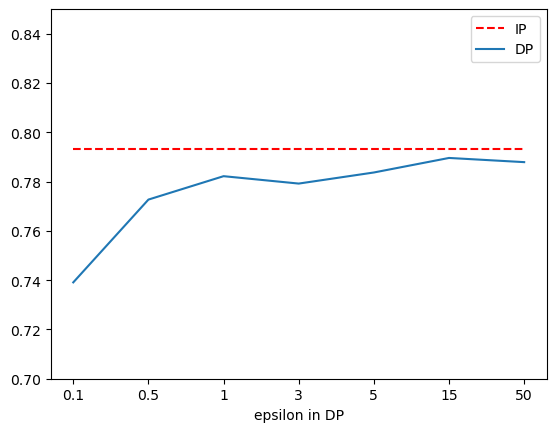

In [64]:
#here onwards plotting the acc_score for epsilon values and ip models acc_score has been calculate for say epsilon 3 ≈(noise_multiplier 0.65 in compute_sgd)
#plt.yticks([0.70, 0.75, 0.80, 0.90,0.95],["0.70","0.75","0.80","0.85","0.90"])
epsilon_list = ['0.1', '0.5', '1', '3', '5', '15', '50']
plt.xticks([0,1,2,3,4,5,6], epsilon_list)

plt.ylim([0.7,0.85])
acc_DP = [ 0.7391, 0.7727, 0.7822, 0.7792, 0.7837, 0.7896, 0.7879]
ipdd_acc=[0.7934]*len(acc_DP)
plt.plot(ipdd_acc, 'r--', label = "IP" )
plt.plot(acc_DP, label="DP")
plt.xlabel("epsilon in DP")
plt.legend()
plt.savefig("SUSY DPvsOnlineIP.pdf",dpi=300, bbox_inches='tight')